In [2]:
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

# Data Generator

In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, img_height=64, img_width=64, batch_size=32, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.file_paths = file_paths
        self.labels = labels
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = [self.load_and_preprocess_image(file) for file in batch_files]
        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = list(range(len(self.file_paths)))
            random.shuffle(indices)

            self.file_paths = [self.file_paths[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]

    def load_and_preprocess_image(self, path):
        img = tf.keras.preprocessing.image.load_img(path, target_size=(self.img_height, self.img_width))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img / 255.0 

## Get all the file paths

In [4]:
cartoon_dir = '/kaggle/input/cartoon-faces-googles-cartoon-set/cartoonset100k_jpg'
anime_dir = '/kaggle/input/animefacedataset/images'
batch_size = 32
img_height = 64
img_width = 64

all_subdirs = [name for name in os.listdir(cartoon_dir) if os.path.isdir(os.path.join(cartoon_dir, name))]
random.seed(42)
chosen_subdirs = random.sample(all_subdirs, 5)

file_paths_cartoon = []
for subdir in chosen_subdirs:
    subdir_path = os.path.join(cartoon_dir, subdir)
    for root, _, files in os.walk(subdir_path):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                file_paths_cartoon.append(os.path.join(root, file))

file_paths_anime = []
for root, _, files in os.walk(anime_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            file_paths_anime.append(os.path.join(root, file))

file_paths_cartoon = random.sample(file_paths_cartoon, 15000) #len(file_paths_cartoon) // 2)
file_paths_anime = random.sample(file_paths_anime, 15000) #len(file_paths_anime) // 2)

In [5]:
file_paths = file_paths_cartoon + file_paths_anime
labels = [0] * len(file_paths_cartoon) + [1] * len(file_paths_anime)
labels = tf.keras.utils.to_categorical(labels, num_classes=2)

In [6]:
train_generator = DataGenerator(file_paths, labels, img_height, img_width, batch_size)

## Some examples of the dataset

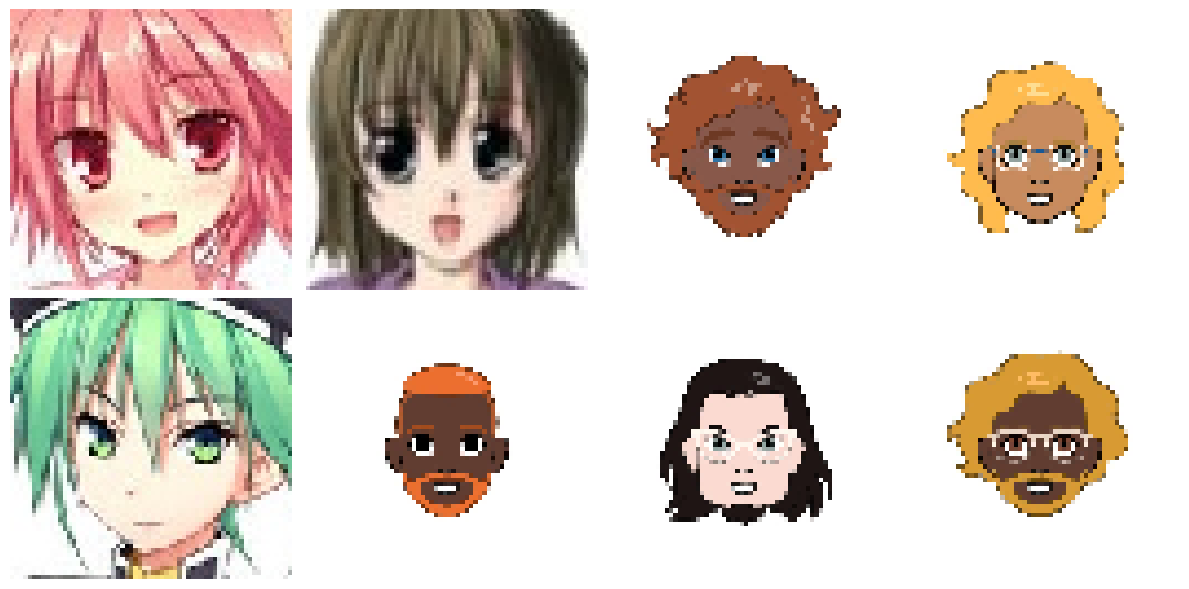

In [11]:
def show_random_images(generator, num_images=8):
    random_indices = np.random.randint(0, len(generator), size=num_images)
    plt.figure(figsize=(12, 6))

    for i, idx in enumerate(random_indices):
        batch_images, x = generator[idx]
        plt.subplot(2, 4, i + 1)
        plt.imshow(batch_images[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(train_generator, num_images=8)

# Model

## Encoder part

In [45]:
latent_dim = 256
num_classes = 2  # Two classes: anime and cartoon
img_height, img_width = 64, 64

# Encoder
image_inputs = layers.Input(shape=(img_height, img_width, 3))
label_inputs = layers.Input(shape=(num_classes,))

# Expand labels to the same size as image inputs
label_inputs_expanded = layers.Reshape((1, 1, num_classes))(label_inputs)
label_inputs_expanded = layers.UpSampling2D(size=(img_height, img_width))(label_inputs_expanded)

x = layers.Concatenate(axis=-1)([image_inputs, label_inputs_expanded])

x = layers.Conv2D(16, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(32, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(64, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(128, kernel_size=3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

## This class is used to do the sampling task

In [46]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling(name="z")([z_mean, z_log_var])

## Decoder part

In [47]:
# Decoder
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Concatenate(axis=-1)([decoder_inputs, label_inputs])
x = layers.Dense(4 * 4 * 128, activation='relu')(x)
x = layers.Reshape((4, 4, 128))(x)

x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', output_padding=1)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', output_padding=1)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', output_padding=1)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', output_padding=1)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

decoder_outputs = layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)

In [48]:
encoder = models.Model([image_inputs, label_inputs], [z_mean, z_log_var, z], name='encoder')
decoder = models.Model([decoder_inputs, label_inputs], decoder_outputs, name='decoder')

## Conditional VAE model

In [54]:
class CVAEModel(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs, training=False):
        images, labels = inputs
        z_mean, z_log_var, z = self.encoder([images, labels])
        reconstructed = self.decoder([z, labels])
        return reconstructed

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([images, labels])
            reconstructed = self.decoder([z, labels])
            reconstruction_loss = 100*tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.keras.layers.Flatten()(images), tf.keras.layers.Flatten()(reconstructed))))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

In [55]:
cvae = CVAEModel(encoder, decoder)
cvae.compile(optimizer='adam')

In [56]:
cvae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1, 2)   │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64, 2) │          0 │ reshape_4[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64, 5) │          0 │ input_layer_6[0]… │
│ (Concatenate)       │                   │            │ up_sampling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │        736 │ concatenate_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 32,    │          0 │ re_lu_16[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_17 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 16,    │          0 │ re_lu_17[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 8, 8, 64)  │          0 │ re_lu_18[0][0]    │
│ (MaxPooling2D)      │                   │            │                 

 Total params: 1,147,776 (4.38 MB)

 Trainable params: 1,147,296 (4.38 MB)

 Non-trainable params: 480 (1.88 KB)

In [57]:
cvae.decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 258)       │          0 │ input_layer_8[0]… │
│ (Concatenate)       │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │    530,432 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 4, 4, 128) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 8, 8, 128) │    147,584 │ reshape_5[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 16, 16,    │     73,792 │ re_lu_20[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_12 │ (None, 32, 32,    │     18,464 │ re_lu_21[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_13 │ (None, 64, 64,    │      4,624 │ re_lu_22[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 64, 64, 3) │        435 │ re_lu_23[0][0]  

 Total params: 776,291 (2.96 MB)

 Trainable params: 775,811 (2.96 MB)

 Non-trainable params: 480 (1.88 KB)

In [58]:
history = cvae.fit(train_generator, epochs=20)

Epoch 1/20
  5/937 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - kl_loss: 5.6791 - loss: 1256.1670 - reconstruction_loss: 1250.4879 

W0000 00:00:1720536372.283667     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720536372.288865     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


937/937 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - kl_loss: 21.2213 - loss: 1177.7090 - reconstruction_loss: 1156.4877
Epoch 2/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - kl_loss: 25.3735 - loss: 1157.5608 - reconstruction_loss: 1132.1874
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - kl_loss: 27.3228 - loss: 1139.9620 - reconstruction_loss: 1112.6392
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - kl_loss: 27.8414 - loss: 1128.3452 - reconstruction_loss: 1100.5038
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - kl_loss: 27.6024 - loss: 1120.6868 - reconstruction_loss: 1093.0844
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - kl_loss: 27.2402 - loss: 1114.7715 - reconstruction_loss: 1087.5314
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - kl_loss: 27.1281 - loss: 1110.7318 - reconstruction_loss: 1083.6036
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - kl_loss: 27.0706 - loss: 1107.2914 - reconstruction_loss: 1080.2208
Epoch 9/20
937/937 

# Results

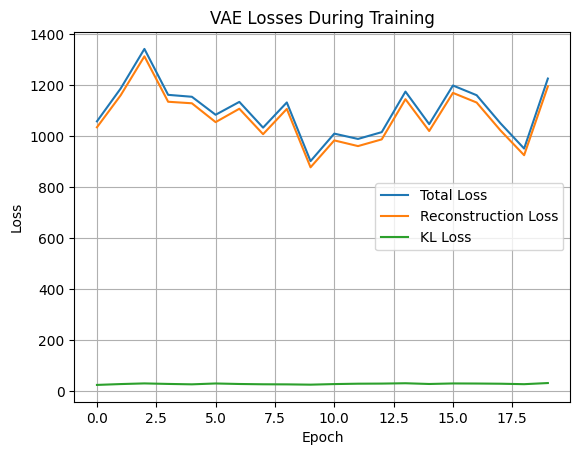

In [59]:
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Losses During Training')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
def plot_generated_images(generated_images, num_images=8):
    plt.figure(figsize=(20, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

def generate_images(model, num_images, label):
    random_latent_vectors = np.random.normal(size=(num_images, latent_dim))
    repeated_labels = np.repeat(np.expand_dims(label, axis=0), num_images, axis=0)
    generated_images = model.decoder.predict([random_latent_vectors, repeated_labels])
    return generated_images

In [61]:
anime_label = tf.keras.utils.to_categorical([1], num_classes=2)[0]
cartoon_label = tf.keras.utils.to_categorical([0], num_classes=2)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


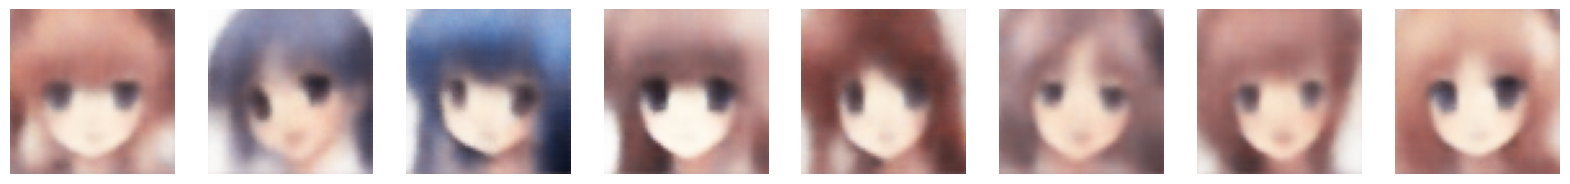

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


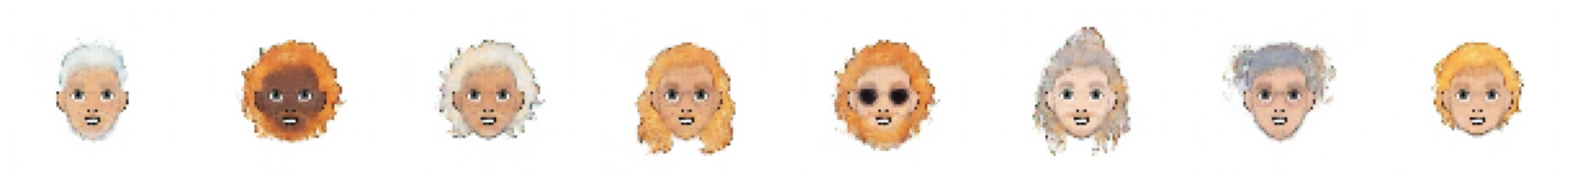

In [67]:
generated_anime_images = generate_images(cvae, num_images=8, label=anime_label)
plot_generated_images(generated_anime_images)

generated_cartoon_images = generate_images(cvae, num_images=8, label=cartoon_label)
plot_generated_images(generated_cartoon_images)